<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 9: Filterung
## Synthetischer Brockenpluton mit FFT und inverse FFT
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib_modelling
tiny=1e-15

In [2]:
lib_modelling.change_fontsize(SMALL_SIZE=12)

----
## 3D model of plutonic body

### Create 2D grid

In [3]:
nx=100
ny=100
xmin=-50000; xmax=50000
ymin=-50000; ymax=50000
x = np.linspace(xmin,xmax, nx)
y = np.linspace(ymin,ymax, ny)
# re-mesh for 2D plot
X, Y = np.meshgrid(y,x)

### Create 2D wavenumber field:

In [4]:
kx     = (-nx/2 + np.arange(0,nx))*2*np.pi/(xmax-xmin)
ky     = (-ny/2 + np.arange(0,ny))*2*np.pi/(ymax-ymin)
KX, KY = np.meshgrid(kx, ky)
print(KX.shape,KY.shape)

(100, 100) (100, 100)


### Calculate Bouguer gravity

For spherical intrusion, add some random noise.

In [5]:
boug = np.zeros(nx*ny).reshape(nx,ny)

for i in range(boug.shape[0]):
    for j in range(boug.shape[1]):
        gx,gy,gz = lib_modelling.grav_sphere(xo=X[i,j],yo=Y[i,j],zo=0,xp=0,yp=0,zp=25.e3,radius=20.e3,rho=200)
        boug[i,j] = boug[i,j] + gz
        
np.random.seed(1234)
boug = boug + 0.9*((np.random.random(nx*ny)-0.5)*2).reshape(nx,ny)

### Fourier transform of 2D Bouguer gravity

In [6]:
# forward 2D FFT
F      = np.fft.fft2(boug)
F      = np.fft.fftshift(F)  # Shift the zero-frequency component to the center of the spectrum.
power  = np.abs(F)**2
power  = 20*np.log10((power+tiny)/power.max())
F      = np.fft.ifftshift(F)

print(F.shape)

(100, 100)


----
## Filter: upward continuation
$$
F[g_{up}] = F[g] F[\Psi_{up}]
$$
$$
F[\Psi_{up}] = e^{-|k|z}
$$

(100, 100)


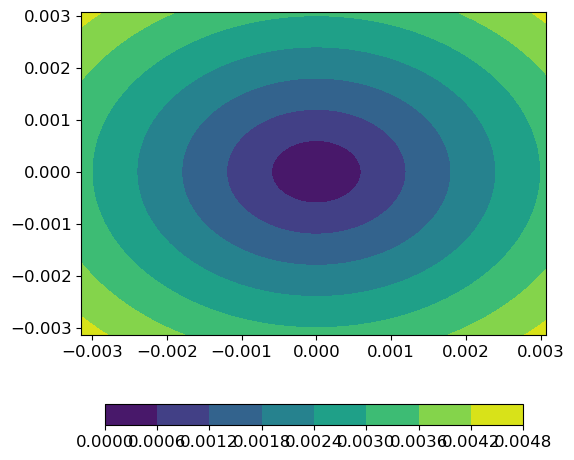

In [7]:
K = np.sqrt(KX**2 + KY**2)
deltaz = 100.
print(K.shape)
Fup = np.exp(-K*deltaz)

fig,axs = plt.subplots(1,1,figsize=(6.0,6.0))
CS1=axs.contourf(KX,KY,K)
cbar = fig.colorbar(CS1,ax=axs,orientation="horizontal",shrink=0.9)

### Inverse Fourier transform of 2D Bouguer gravity with applied filter

In [8]:
# inverse 2D FFT
#F2             = np.fft.ifftshift(F)
F2 = np.copy(F)
boug_recovered = np.fft.ifft2(F2*Fup).real

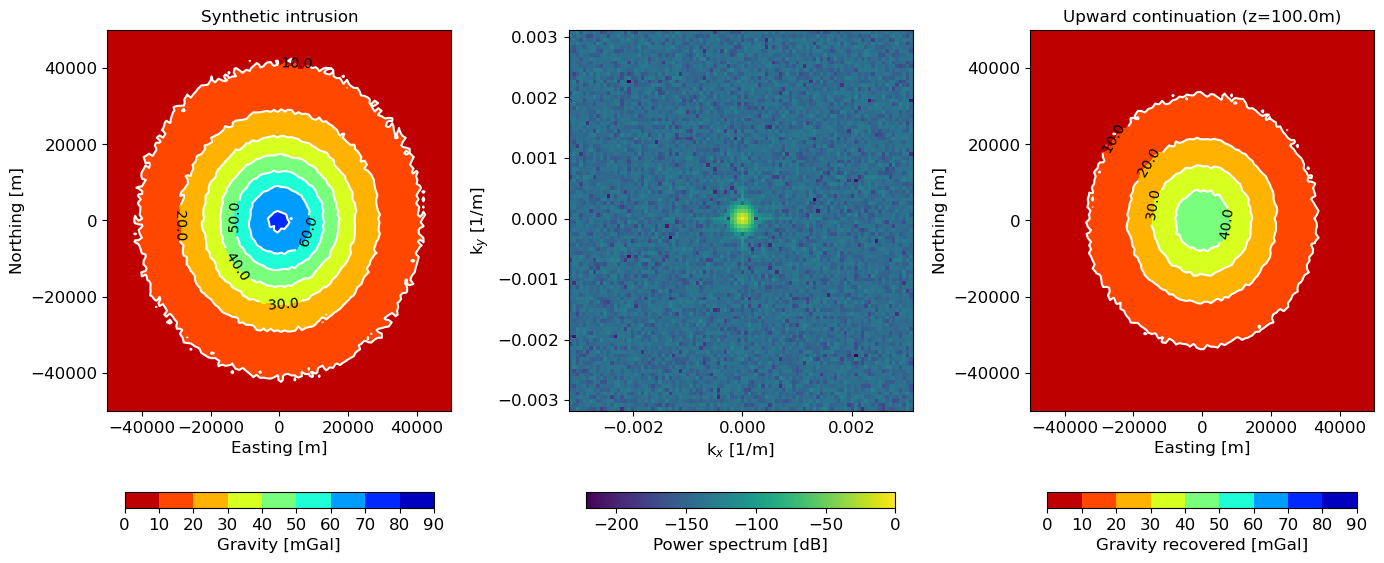

In [9]:
fig,axs = plt.subplots(1,3,figsize=(14.0,6.0))
color_levels=[0,10,20,30,40,50,60,70,80,90]

axs[0].set_title('Synthetic intrusion')
axs[0].set_xlabel('Easting [m]')
axs[0].set_ylabel('Northing [m]')
CS1=axs[0].contourf(X, Y, boug,cmap=plt.cm.jet_r,levels=color_levels)
CS2=axs[0].contour(X, Y, boug,colors='white',levels=color_levels)
axs[0].clabel(CS2, inline=1, fontsize=10,fmt='%5.1f',colors='black')
cbar = fig.colorbar(CS1,ax=axs[0],orientation="horizontal",shrink=0.9)
cbar.ax.set_xlabel('Gravity [mGal]')

axs[1].set_xlabel('k$_x$ [1/m]')
axs[1].set_ylabel('k$_y$ [1/m]')
#CS5=axs[1].pcolormesh(KX,KY,np.abs(F))
CS5=axs[1].pcolormesh(KX,KY,power)
cbar = fig.colorbar(CS5,ax=axs[1],orientation="horizontal",shrink=0.9)
cbar.ax.set_xlabel('Power spectrum [dB]')

axs[2].set_title('Upward continuation (z='+str(deltaz)+'m)')
axs[2].set_xlabel('Easting [m]')
axs[2].set_ylabel('Northing [m]')
CS3=axs[2].contourf(X, Y, boug_recovered,cmap=plt.cm.jet_r,levels=color_levels)
CS4=axs[2].contour(X, Y, boug_recovered,colors='white',levels=color_levels)
axs[2].clabel(CS4, inline=1, fontsize=10,fmt='%5.1f',colors='black')
cbar = fig.colorbar(CS3,ax=axs[2],orientation="horizontal",shrink=0.9)
cbar.ax.set_xlabel('Gravity recovered [mGal]')

plt.tight_layout()

----
## Other filter ...

... done